<a href="https://www.kaggle.com/markessery/seti-deep-learning-signal-image-processing?scriptVersionId=87317338" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras import layers
from keras.preprocessing import image
from keras import Sequential
from keras.layers import Dense,Activation, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from keras.metrics import categorical_crossentropy
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,max_error, explained_variance_score,median_absolute_error, accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,  cross_validate,  cross_val_score 
import random
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import *
import cv2
import math
import joblib
from scipy import stats
import gc


img_w= 256
img_h=256

In [2]:
train_path= "../input/seti-data/primary_small/train/"
valid_path= '../input/seti-data/primary_small/valid/'
test_path= '../input/seti-data/primary_small/test/'

In [3]:
class ImageData:

    def __init__(self, filepath):
        self.filepath= filepath
        self.X_data= []
        self.y_data= []
        self.X_gray= []
        self.X_binary=[]
        self.classes=[]
        self.y_categorical= []
           
            
            
    def split_and_resize(self): 

        self.classes= sorted(os.listdir(self.filepath))

        for c in range(len(self.classes)):
            path = os.path.join(self.filepath, self.classes[c])
            signal_type= self.classes[c]
            
            for i in os.listdir(path):
                img= cv2.imread(os.path.join(path, i))
                img= cv2.resize(img, (256, 256))
                
                self.X_data.append(img)
                self.y_data.append(signal_type)
                
        return np.array(self.X_data), np.array(self.y_data)

    
    def grayscale(self):

        for i in range(len(self.X_data)):
            x= cv2.cvtColor(self.X_data[i], cv2.COLOR_BGR2GRAY)
            self.X_gray.append(x)

            
    
    def create_binary_image(self):
        self.grayscale()
        for i in range(len(self.X_gray)):
            img= np.where(self.X_gray[i]>100,1,0)
            self.X_binary.append(img)
        return np.array(self.X_binary)
            
    
    def create_categorical_label(self):
        self.y_categorical = to_categorical([self.classes.index(i) for i in self.y_data])
        return self.y_categorical
    

In [4]:
class FeatureEngineering:
    
    def __init__(self):
        self.lr_rmse=[]
        self.lr_max_error= []
        self.lr_spread= []
        self.lr_av_slope= []
        self.lr_slope= []
        self.y_int= []
        
        self.num_gaps= []
        self.mean_squiggly =[]
        self.num_bright_pix =[]
        self.pct_bright_lines =[]
        self.noisy= []
        self.biggest_gap=[]
#         self.frequent_gap=[]

        
    
        self.Features_DF = pd.DataFrame()
        
    
    def make_df(self):

        img_tuple = [([(i,x,y) for x, y in enumerate(j)]) for i, j in enumerate(self.temp)]

        
        new_list=[]
        for x in range(256):
            for y in range(256):
                new_list.append(img_tuple[x][y])
                
                   #create df from the list, filter for only bright pixels (ie, 1 values)
        df= pd.DataFrame(new_list).rename(columns={0:'Y', 1:"X", 2:'Bright'})
        df= df[df['Bright']==1]
        df.drop(columns='Bright', inplace=True)
        df.reset_index(inplace=True, drop=True)
        self.brightpix_df= df
        self.num_bright_pix.append(len(self.brightpix_df))
        return self.brightpix_df
    

        
    def lin_reg(self, binary_array):

        
        binary_df =  pd.DataFrame(self.make_df())
        Y= binary_df['Y']
        X= binary_df.drop(columns='Y')
        
        LinReg = LinearRegression()
        LinReg.fit(X,Y)
        
        self.y_pred= LinReg.predict(X)
        
        self.lr_rmse.append(math.sqrt(mean_squared_error(Y, self.y_pred)))
        self.lr_max_error.append(max_error(Y, self.y_pred))
        self.lr_av_slope.append(abs(LinReg.coef_))
        self.lr_slope.append(LinReg.coef_)
        self.y_int.append(LinReg.intercept_)
        self.lr_spread.append(np.max(X)- np.min(X))
        
    def gap_detector(self):
        self.num_gaps.append(len(self.brightpix_df[self.brightpix_df.Y.diff()> self.thresh]))
            
    def mean_squiggliness(self):
        if self.brightpix_df.X.diff().apply(abs).mean() ==np.nan:
            self.mean_squiggly.append(0)
        else:
            self.mean_squiggly.append(self.brightpix_df.X.diff().apply(abs).mean())
            

    def big_and_most_gap(self):
        
        diffs = self.brightpix_df.Y.diff()
        gap_info= pd.DataFrame(diffs.value_counts()).reset_index().rename(columns={'index':'Gap Size', 'Y':'Gap Freq'})
        freq_gap = gap_info.sort_values(by='Gap Freq', ascending=False)
        
        
                                        # ***********
        if np.max(gap_info['Gap Size']) > self.thresh:
            self.biggest_gap.append(np.max(gap_info['Gap Size']))
        else:
            self.biggest_gap.append(0)
            

    
    def find_bright_lines(self):
        lines=[]
        
        for line in range(256):
            if np.max(self.temp[line]) >0:
                lines.append(1)
        self.pct_bright_lines.append(len(lines)/256)
        

    def detect_noise(self):
        if len(self.brightpix_df)>150:
            self.noisy.append(1)
        else:
            self.noisy.append(0)
    

    
    
    
    def assemble(self, binary_array, thresh=20):
        self.binary_array= binary_array
        self.thresh= thresh
        
        for i in range(len(self.binary_array)):
            self.temp = self.binary_array[i]
            
            self.lin_reg(self.temp)
            self.big_and_most_gap()
            
            
            
            
            self.gap_detector()
            self.mean_squiggliness()
            self.find_bright_lines()
            self.detect_noise()
        self.Features_DF = pd.DataFrame(np.column_stack([self.lr_rmse, self.lr_max_error, self.lr_spread, self.lr_av_slope,
                                        self.noisy, self.mean_squiggly, self.num_bright_pix, self.pct_bright_lines, 
                                        self.num_gaps, self.biggest_gap]),
                                       columns=['RMSE', 'Max Error', 'Spread','Slope', 'Is Noisy','Mean Squiggliness',
                                               'Num Bright Pix', 'Pct Bright Lines','Num Gaps','Biggest Gap'])
        self.Features_DF.fillna(0, inplace=True)
        return self.Features_DF
            
        

In [5]:

class Ensemble():
    
    def __init__(self):
        self.classes= ['brightpixel','narrowband', 'narrowbanddrd', 'noise', 'squarepulsednarrowband', 'squiggle', 'squigglesquarepulsednarrowband']


    
    def fit(self, X_train_images, train_features, y_train):
        self.X_train_images= X_train_images
        self.X_train_features= train_features
        self.y_train= y_train
        self.y_train_cat= to_categorical([self.classes.index(i) for i in self.y_train])
        
        
        # get probabilities of each class
        
        self.RFC = RandomForestClassifier(criterion='entropy', max_depth=10, max_features= 9, n_estimators= 108)
        self.RFC.fit(self.X_train_features, self.y_train)
        
        
        
        
        #  create combo train df
        
        self.cnn_model= tf.keras.models.load_model('../input/vgg-model/final_vgg16.h5')
        self.cnn_model.fit(self.X_train_images, self.y_train_cat)
        train_preds= self.cnn_model.predict(self.X_train_images)
        train_probs= pd.DataFrame(train_preds)
        train_probs.rename(columns={0:'BP Prob', 1:'NB Prob', 2:'NBDRD Prob', 3:'N Prob',4:'SPNB Prob',5:'S Prob',6:'SSPNB Prob'}, inplace=True)

        
        
        self.COMBO_X_TRAIN= pd.concat([self.X_train_features, train_probs], axis=1)
        
        
        self.Ensemble_Forest=  RandomForestClassifier(criterion='entropy', n_estimators= 102, max_features=9, max_depth=7)
        self.Ensemble_Forest.fit(self.COMBO_X_TRAIN, self.y_train)    
    
        

    
    def predict(self, XTEST  , TESTFEATURES,  YTEST):
        self.X_test_images= XTEST
        self.X_test_features= TESTFEATURES
        self.y_test= YTEST

        
        # create combo df for test set

        combo_test_preds= self.cnn_model.predict(self.X_test_images)
        combo_test_probs= pd.DataFrame(combo_test_preds)
        combo_test_probs.rename(columns={0:'BP Prob', 1:'NB Prob', 2:'NBDRD Prob', 3:'N Prob',4:'SPNB Prob',5:'S Prob',6:'SSPNB Prob'}, inplace=True)
    
        
        
        
        self.COMBO_X_TEST= pd.concat([self.X_test_features, combo_test_probs], axis=1)
        
        
        self.ensemble_predictions = self.Ensemble_Forest.predict(self.COMBO_X_TEST)
        

    
        self.ensemble_accuracy= accuracy_score(self.y_test, self.ensemble_predictions)
        
       

In [6]:
train= ImageData(train_path)
X_tr, y_tr= train.split_and_resize()
X_tr_bin= train.create_binary_image()

classes= train.classes

In [7]:
# valid= ImageData(valid_path)
# X_val, y_val= valid.split_and_resize()
# X_val_bin= valid.create_binary_image()

In [8]:
test= ImageData(test_path)
X_te, y_te= test.split_and_resize()
X_te_bin= test.create_binary_image()

In [9]:
fe_train= FeatureEngineering()
TRAIN_DF= fe_train.assemble(X_tr_bin, thresh=10)

In [10]:
# fe_valid = FeatureEngineering()
# VAL_DF= fe_valid.assemble(X_val_bin, thresh=10)

In [11]:
fe_test= FeatureEngineering()
TEST_DF= fe_test.assemble(X_te_bin, thresh=10)

In [12]:
del X_tr_bin
del X_te_bin
del train
del test
del FeatureEngineering
del fe_train
del fe_test



In [13]:
gc.collect()

56

In [14]:
a= Ensemble()
a.fit(X_tr, TRAIN_DF, y_tr)
a.predict(X_te,TEST_DF, y_te)

2022-02-08 16:25:09.970701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 16:25:10.117089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 16:25:10.117911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 16:25:10.119777: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

175/175 [==============================] - 15s 47ms/step - loss: 0.3620 - accuracy: 0.8821


2022-02-08 16:25:35.468768: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1101004800 exceeds 10% of free system memory.
2022-02-08 16:25:36.769404: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1101004800 exceeds 10% of free system memory.


In [15]:
a.ensemble_accuracy

0.8585714285714285

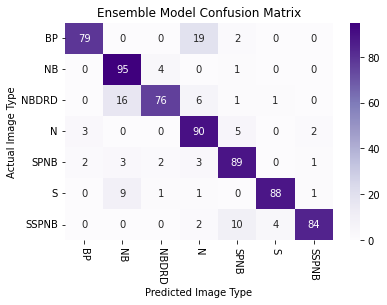

In [16]:
classes_abv= ['BP','NB','NBDRD','N','SPNB','S','SSPNB']

cm= confusion_matrix(a.y_test, a.ensemble_predictions)
cm_df= pd.DataFrame(cm, columns=list(classes_abv), index= list(classes_abv))
cm_df
ax = sns.heatmap(cm, annot=True, cmap='Purples')

ax.set_title('Ensemble Model Confusion Matrix')
ax.set_xlabel('Predicted Image Type')
ax.set_ylabel('Actual Image Type')
ax.xaxis.set_ticklabels(list(classes_abv), rotation= 270)
ax.yaxis.set_ticklabels(list(classes_abv), rotation= 360)

plt.show()

In [17]:
cls_report= classification_report(a.y_test, a.ensemble_predictions, output_dict= True)
cls_report= pd.DataFrame(cls_report).T
cls_report

,precision,recall,f1-score,support
brightpixel,0.940476,0.790000,0.858696,100.000000
narrowband,0.772358,0.950000,0.852018,100.000000
narrowbanddrd,0.915663,0.760000,0.830601,100.000000
noise,0.743802,0.900000,0.814480,100.000000
squarepulsednarrowband,0.824074,0.890000,0.855769,100.000000
squiggle,0.946237,0.880000,0.911917,100.000000
squigglesquarepulsednarrowband,0.954545,0.840000,0.893617,100.000000
accuracy,0.858571,0.858571,0.858571,0.858571
macro avg,0.871022,0.858571,0.859585,700.000000
weighted avg,0.871022,0.858571,0.859585,700.000000
